## What I Do

1. 基于pyTorch实现一个自定义的卷积神经网络
2. 通过torchvision加载MNIST数据集
3. 学习使用Microsoft Visio绘制卷积神经网络结构示意图
![](https://jaggar-oss.oss-cn-shanghai.aliyuncs.com/img/ConvNet.png)

## 1. 载入数据集及预处理

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
# 设置超参数
num_epochs = 5
batch_size = 512
learning_rate = 0.001

In [3]:
# CPU/GPU运行设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# 加载MNIST数据集
train_dataset = torchvision.datasets.MNIST(
    root = "./data/", train = True, transform = transforms.ToTensor(), download = False)
test_dataset = torchvision.datasets.MNIST(
    root = "./data", train = False, transform = transforms.ToTensor(), download = False)

In [5]:
print("train size:\t", train_dataset.data.shape)
print("test size:\t", test_dataset.data.shape)

train size:	 torch.Size([60000, 28, 28])
test size:	 torch.Size([10000, 28, 28])


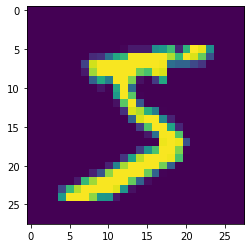

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0])
plt.savefig('fig.png')

In [7]:
# 配置Data loader，一次训练载入一个batch_size的数据
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size=batch_size, shuffle=False)

## 2. 神经网络的搭建

In [8]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNet, self).__init__()
        # 定义卷积模块self_layer1, self_layer2
        self.layer1 = nn.Sequential(
            # 输入通道1，输出通道16，卷积核5*5，边衬2单位
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            # 批量归一化
            nn.BatchNorm2d(16),
            # 激活函数层
            nn.ReLU(),
            # 最大池化层
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc = nn.Linear(7 * 7 * 32, num_classes)
        
        
    def forward(self, x):
        #print("x size:\t", x.shape)
        out = self.layer1(x)   #; print("out1 size:\t", out.shape)
        out = self.layer2(out) #; print("out2 size:\t", out.shape)
        out = out.reshape(out.size(0), -1) #; print("out3 size:\t", out.shape)
        out = self.fc(out)    #; print("outFinal size:\t", out.shape)

        return out

In [9]:
model = ConvNet().to(device)

## 3. 损失函数+优化方法

- 多分类问题，可采用交叉熵损失函数
- Adam (adaptive moment estimation) 梯度下降

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. 模型训练与测试

### 4.1. 训练模型

In [11]:
total_step = len(train_loader)
Loss = []
# 每一次迭代
for epoch in range(num_epochs):
    # 每一批次数据集
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device); labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {: .4f}".format(
                epoch+1, num_epochs, i+1, total_step, loss.item())
            )
        Loss.append(loss.item())

Epoch [1/5], Step [100/118], Loss:  0.1152
Epoch [2/5], Step [100/118], Loss:  0.0601
Epoch [3/5], Step [100/118], Loss:  0.0388
Epoch [4/5], Step [100/118], Loss:  0.0414
Epoch [5/5], Step [100/118], Loss:  0.0336


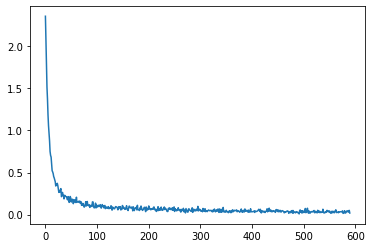

In [12]:
plt.plot(Loss)

### 4.2. 测试模型效果

In [13]:
model.eval()
pred_prob0 = []
true_label = []
with torch.no_grad():
    correct = 0; total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        probs = nn.Softmax(dim=1)(outputs)
        pred_prob0.extend(probs[:,0].tolist())
        true_label.extend(labels.tolist())
        predicted = torch.max(probs, 1).indices
        # _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(
        "Test Accuracy of the model on the 10000 test images:{} %".format(
            100 * correct / total)
    )

Test Accuracy of the model on the 10000 test images:98.76 %


In [20]:
ture0 = true_label
for i, label in enumerate(true_label):
    if label == 0:
        ture0[i] = 1
    else:
        ture0[i] = 0

In [21]:
from sklearn.metrics import roc_curve, auc

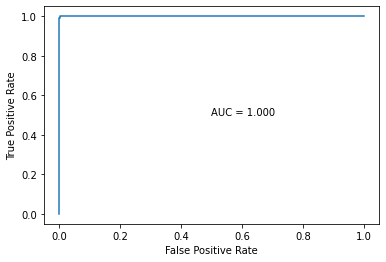

In [22]:
fpr, tpr, thresholds = roc_curve(ture0, pred_prob0)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

roc_auc = auc(fpr, tpr)
plt.text(0.5, 0.5, 'AUC = {:.3f}'.format(roc_auc))

plt.show()